In [5]:
import IPython
from pydub import AudioSegment
import os
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Bidirectional, Reshape,Flatten, Lambda, Input,\
    Masking, Convolution1D, BatchNormalization, GRU, Conv1D, RepeatVector, Conv2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import ZeroPadding1D, Convolution1D, ZeroPadding2D, Convolution2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import TimeDistributed, Dropout
from tensorflow.keras.layers import Add  # , # concatenate BAD FOR COREML
from tensorflow.keras.utils import *
from tensorflow.keras.activations import relu

import tensorflow as tf

*Audio Data Generator*

In [32]:

from pydub import AudioSegment
import numpy as np
import csv
import pandas as pd
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt

def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000       #8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

def get_input(path,maxlen_ms = 10000):
    x = graph_spectrogram(path)
    return x.T

char_to_idx = {'a':0,'b':1,'c':2,'d':3,'e':4,'f':5,'g':6,'h':7,'i':8,'j':9,'k':10,'l':11,'m':12,'n':13,'o':14,'p':15,'q':16,'r':17,'s':18,'t':19,'u':20,'v':21,'w':22,'x':23,'y':24,'z':25,"'":26,' ':27}
idx_to_char = { char_to_idx[key]:key for key in char_to_idx}

def get_output(csv_file,idx,maxlen=250):
    Y = []
    length = 0
    read = pd.read_csv(csv_file,usecols = [1])
    label = str(read['text'][idx])
    for c in label:
        Y.append(char_to_idx[c])
    if len(Y)>maxlen:
        Y = [-1]*maxlen
    else:
        length = len(Y)
        Y = Y + (maxlen-len(Y))*[-1]
    return Y,length



#complete path of csv file and files needed
def data_generator(files,csv_file,batch_size=64):
    while True:
        batch_paths = np.random.choice(a=files,size=batch_size)

        batch_input  = []
        batch_output = []
        label_length = []
        
        for input_path in batch_paths:
          input = get_input(input_path)
          idx = int(input_path.replace('.wav','').split("sample-")[1])
          output,length = get_output(csv_file,idx )
          label_length.append(length)
          batch_input += [input]
          batch_output += [ output ]
       # print(batch_input,batch_input[0].shape)
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        batch_label_length = np.array(label_length)
        
        yield([batch_x,batch_y,np.array(np.ones(batch_size)*738),batch_label_length], np.zeros(batch_y.shape) )

*CTC LOSS*:

In [33]:
# Define CTC lamda function for lambda layer
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

#since y_pred is ctc_loss it will be returned as loss
def ctc(y_true, y_pred):
    return y_pred

*Model Architecture*:

In [34]:
def model(input_shape):
    
    X_input = Input(shape = input_shape)
    
    X = BatchNormalization()(X_input)# applying batch noramlization to input
    # 3 Convolutions
    X = Conv1D(filters =100,kernel_size = 15,strides = 2,activation = 'relu')(X)
    X = Conv1D(filters = 100,kernel_size = 15,strides = 2,activation = 'relu')(X)
    X = Conv1D(filters = 100,kernel_size = 15,strides = 2,activation = 'relu')(X)
    
    X = BatchNormalization()(X)#applying batch norm
    
    #7 bidirectionals
    X = Bidirectional(GRU(512,return_sequences=True,activation='relu'))(X)
    X = Bidirectional(GRU(512,return_sequences=True,activation='relu'))(X)
    X = Bidirectional(GRU(512,return_sequences=True,activation='relu'))(X)
    X = Bidirectional(GRU(512,return_sequences=True,activation='relu'))(X)
    X = Bidirectional(GRU(512,return_sequences=True,activation='relu'))(X)
    X = Bidirectional(GRU(512,return_sequences=True,activation='relu'))(X)
    X = Bidirectional(GRU(512,return_sequences=True,activation='relu'))(X)
    
    X = BatchNormalization()(X)#applying batch norm
    
    X = TimeDistributed(Dense(len(char_to_idx)+1,activation="softmax"))(X)
    
    labels = Input(name='the_labels', shape=[None], dtype='int32')
    input_length = Input(name='input_length', shape=[1], dtype='int32')
    label_length = Input(name='label_length', shape=[1], dtype='int32')

    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func,output_shape = (1,) ,name='ctc')([X,labels,input_length,label_length])

    model = Model(inputs=[X_input, labels, input_length, label_length], outputs=loss_out)

    return model

In [35]:
m = model(input_shape=(5998,101))

In [36]:
m.compile(optimizer = Adam(),loss = ctc)
m.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 5998, 101)]  0                                            
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 5998, 101)    404         input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 2992, 100)    151600      batch_normalization_6[0][0]      
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 1489, 100)    150100      conv1d_6[0][0]                   
____________________________________________________________________________________________

In [44]:
files = os.listdir('/mnt/d/commonvoice/ignore/code_wav')
files = ['/mnt/d/commonvoice/cv-valid-test_wav_bg/'+s for s in files]
print(files[1847].replace('.wav','').split("sample-")[1])

IndexError: list index out of range

(5998, 101)


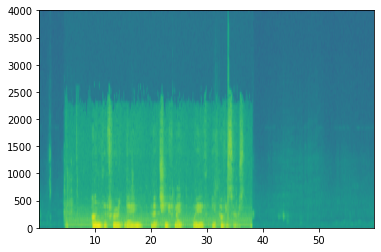

In [38]:
x=get_input(files[1847])
print(x.shape)

In [41]:
x = get_output('/mnt/d/commonvoice/ignore/code.csv',1847)
print(x,len(x))
y = [idx_to_char[s] for s in x if s is not -1]
print(y)

KeyError: 1847

Epoch 1/2
2/2 [==============================] - 59s 29s/step - loss: 271.9431
Epoch 2/2
2/2 [==============================] - 59s 30s/step - loss: 195.2940


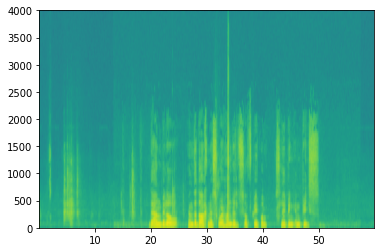

In [45]:
m.fit(data_generator(files,'/mnt/d/commonvoice/ignore/code.csv',batch_size=10),steps_per_epoch=26//10,epochs=2)

In [46]:
import h5py

In [47]:
m.save('/mnt/d/commonvoice/asr_model.h5')

In [48]:
def decode_predict_ctc(out, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
      beam_width = top_paths
    for i in range(top_paths):
      lables = K.get_value(K.ctc_decode(out, input_length=np.ones(out.shape[0])*out.shape[1],
                           greedy=False, beam_width=beam_width, top_paths=top_paths)[0][i])[0]
      #text = labels_to_text(lables)
      results.append(labels)
    return results
  
def predit_a_voice(input, top_paths = 1):
  net_out_value = m.predict(input)
  top_pred_texts = decode_predict_ctc(net_out_value, top_paths)
  return top_pred_texts

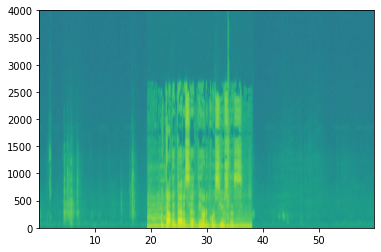

In [49]:
x = get_input(files[0])

In [50]:
y,length = get_output('/mnt/d/commonvoice/ignore/code.csv',0)

In [54]:
input = [np.array(x),np.array(y),np.array([738]),np.array([length])]

In [59]:
predit_a_voice(np.array(x).reshape(1,5998,101))

AssertionError: in user code:

    /home/muzzammil/convo/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    /home/muzzammil/convo/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/muzzammil/convo/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/muzzammil/convo/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/muzzammil/convo/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1122 predict_step  **
        return self(x, training=False)
    /home/muzzammil/convo/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/muzzammil/convo/lib/python3.6/site-packages/tensorflow/python/keras/engine/network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /home/muzzammil/convo/lib/python3.6/site-packages/tensorflow/python/keras/engine/network.py:899 _run_internal_graph
        assert str(id(x)) in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output Tensor("ctc_2/Identity:0", shape=(None, 1), dtype=float32)


In [60]:
c = np.expand_dims(x, axis=0)

net_out_value = m.predict(c)
pred_texts = decode_predict_ctc(net_out_value)
pred_texts

AssertionError: in user code:

    /home/muzzammil/convo/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    /home/muzzammil/convo/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/muzzammil/convo/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/muzzammil/convo/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/muzzammil/convo/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1122 predict_step  **
        return self(x, training=False)
    /home/muzzammil/convo/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/muzzammil/convo/lib/python3.6/site-packages/tensorflow/python/keras/engine/network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /home/muzzammil/convo/lib/python3.6/site-packages/tensorflow/python/keras/engine/network.py:899 _run_internal_graph
        assert str(id(x)) in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output Tensor("ctc_2/Identity:0", shape=(None, 1), dtype=float32)
